In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import spacy
import nltk
from spacy.lang.ru.examples import sentences
from nltk.corpus import stopwords
from multiprocessing import Pool
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss, auc, roc_curve
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm.auto import tqdm
RAND = 10

In [ ]:
df = pd.read_excel('dataset.xlsx')

In [ ]:
df

,oid,text,category
0,749208109,СПОЧНО СООБЩЕСТВО ПРОДАЕТСЯ ЗА 1300Р ЗА ПОКУПК...,esport
1,749208109,Пусть это побудет здесь БорьбаВпрямомЭфире How...,esport
2,749208109,Раздача пиздюлей от Мунсунга. HowToFtokenoid Б...,esport
3,749208109,Не знаю как вам но мне стилистика нравится пус...,esport
4,749208109,Скриншоты из новой главы. Тэхунчика показали и...,esport
...,...,...,...
53193,910636962,8 битная буря снова накрыла пикселями автомоби...,autosport
53194,669736851,Ира Сидоркова объясняет как сказалась на ее ма...,autosport
53195,558919241,24 я ракетка мира хорват Марин Чилич обыграл и...,tennis
53196,776944963,Стал известен календарь мужской сборной России...,volleyball


In [ ]:
df = df.drop_duplicates()

In [ ]:
X = df.drop(columns='category', axis=1)
y = df['category']

In [ ]:
X_train_old, X_test_old, y_train_old, y_test_ol = train_test_split(X, y, test_size=0.2, random_state=RAND, shuffle=True, stratify=y)

# Предобработка данных

In [ ]:
! python -m spacy download ru_core_news_sm
nlp = spacy.load('ru_core_news_sm')
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

In [ ]:
def cleaning(text):
    doc = nlp(text)
    ans = [token.lemma_.lower() for token in doc if token.lemma_.lower() not in stop_words and token.lemma_.lower().isalpha()]
    return ' '.join(ans)

def parallelize_dataframe(df, func, n_cores=4):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    results = []
    for i in tqdm(pool.imap(func, df_split), total=n_cores):
        results.append(i)

    pool.close()
    pool.join()
    return pd.concat(results)

def apply_cleaning(df):
    df['text'] = df['text'].apply(lambda x: cleaning(x))
    return df

In [ ]:
X_train_1 = X_train[:8500]
X_train_2 = X_train[8500:17000]
X_train_3 = X_train[17000:25500]
X_train_4 = X_train[25500:34000]
X_train_5 = X_train[34000:]

In [ ]:
X_train_1 = parallelize_dataframe(X_train_1, apply_cleaning)

100%|██████████| 4/4 [05:55<00:00, 88.83s/it] 


In [ ]:
X_train_2 = parallelize_dataframe(X_train_2, apply_cleaning)

100%|██████████| 4/4 [05:55<00:00, 88.81s/it] 


In [ ]:
X_train_3 = parallelize_dataframe(X_train_3, apply_cleaning)

100%|██████████| 4/4 [05:54<00:00, 88.63s/it] 


In [ ]:
X_train_4 = parallelize_dataframe(X_train_4, apply_cleaning)

100%|██████████| 4/4 [05:56<00:00, 89.08s/it]


In [ ]:
X_train_5 = parallelize_dataframe(X_train_5, apply_cleaning)

100%|██████████| 4/4 [05:37<00:00, 84.34s/it] 


In [ ]:
X_train = pd.concat([X_train_1, X_train_2, X_train_3, X_train_4, X_train_5])

In [ ]:
X_test = parallelize_dataframe(X_test, apply_cleaning)

100%|██████████| 4/4 [07:37<00:00, 114.28s/it]


In [ ]:
X_train.drop(columns=['oid'], axis=1, inplace=True)
X_test.drop(columns=['oid'], axis=1, inplace=True)

In [ ]:
dict_labels = {'esport': 0, 'martial_arts': 1, 'tennis': 2, 'basketball': 3,
        'volleyball': 4, 'boardgames': 5, 'athletics': 6, 'winter_sport': 7,
        'football': 8, 'motosport': 9, 'autosport': 10, 'extreme': 11, 'hockey': 12}
def lab_enc(text, dictin):
  return dictin[text]

In [ ]:
y_train['category'] = y_train['category'].apply(lambda x: lab_enc(x, dict_labels))

In [ ]:
y_test['category'] = y_test['category'].apply(lambda x: lab_enc(x, dict_labels))

In [ ]:
df = pd.concat([X_train, X_test])
labels = pd.concat([y_train, y_test])
df['class_name'] = labels
df['class'] = df['class_name'].apply(lambda x: lab_enc(x, dict_labels))

In [ ]:
df = df.reset_index().drop(columns=['index'], axis=1)

In [ ]:
df = df.drop_duplicates()
df = df.reset_index().drop(columns=['index'], axis=1)

In [ ]:
df

,text,class_name,class
0,уход ислам мамедов плотный удушающего реакция ...,martial_arts,1
1,ждать диллона прошлый неделя обещать конец нед...,basketball,3
2,энтони джошуа продолжать подготовка реванш уси...,martial_arts,1
3,мотогонка лёд speetokenoid tokenoid личный чем...,motosport,9
4,присылать ваш беговой фото публикация коммента...,athletics,6
...,...,...,...
47950,карлос алькараз прокомментировать победа четве...,tennis,2
47951,мотоспорт wsbk porttokenoid гонка ltokenoid на...,motosport,9
47952,кокорин пропустит матч специей иза негодования...,esport,0
47953,рафаэль надаль рассказать взаимоотношение фина...,tennis,2


In [ ]:
token_counter = Counter()
def remove_words_with_substring(text, substring):
    pattern = rf'\b\w*{re.escape(substring)}\w*\b'
    result = re.sub(pattern, '', text)
    return ' '.join(result.split())

df['text'] = df['text'].apply(lambda x: remove_words_with_substring(x, 'token'))

In [ ]:
token_counter = Counter()
for one_string in df['text'].values:
    for token in one_string.split():
        token_counter[token] += 1

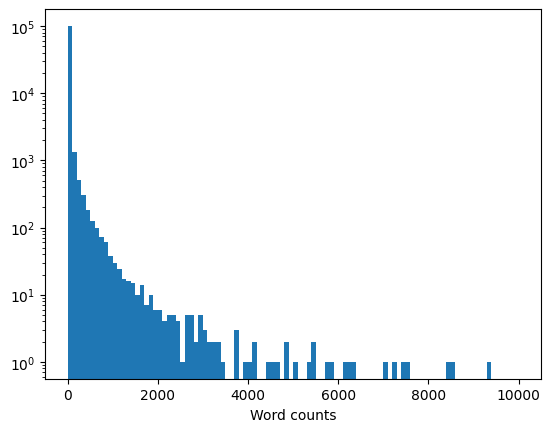

In [ ]:
plt.hist(list(token_counter.values()), range=[0, 10**4], bins=100, log=True)
plt.xlabel("Word counts");

In [ ]:
low_appearance = set()
to_del = set()
for i,v in token_counter.items():
    if len(i) == 1:
      to_del.add(i)

In [ ]:
def delete_garbage(text, garbage):
    return ' '.join([i for i in text.split() if i not in garbage])

df['text'] = df['text'].apply(lambda x: delete_garbage(x, to_del))

In [ ]:
dict_labels = {0:'esport', 1:'martial_arts', 2:'tennis', 3:'basketball',
        4:'volleyball', 5:'boardgames', 6:'athletics', 7:'winter_sport',
        8:'football', 9:'motosport', 10:'autosport', 11:'extreme', 12:'hockey'}

Зависимость метки класса от количество токенов в тексте

In [ ]:
df_ = df.copy()

In [ ]:
def add_len(text):
    return len(text.split())
df_['length'] = df_['text'].apply(add_len)

C:\Users\albin\AppData\Local\Temp\ipykernel_18412\4077276993.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, ha='right')


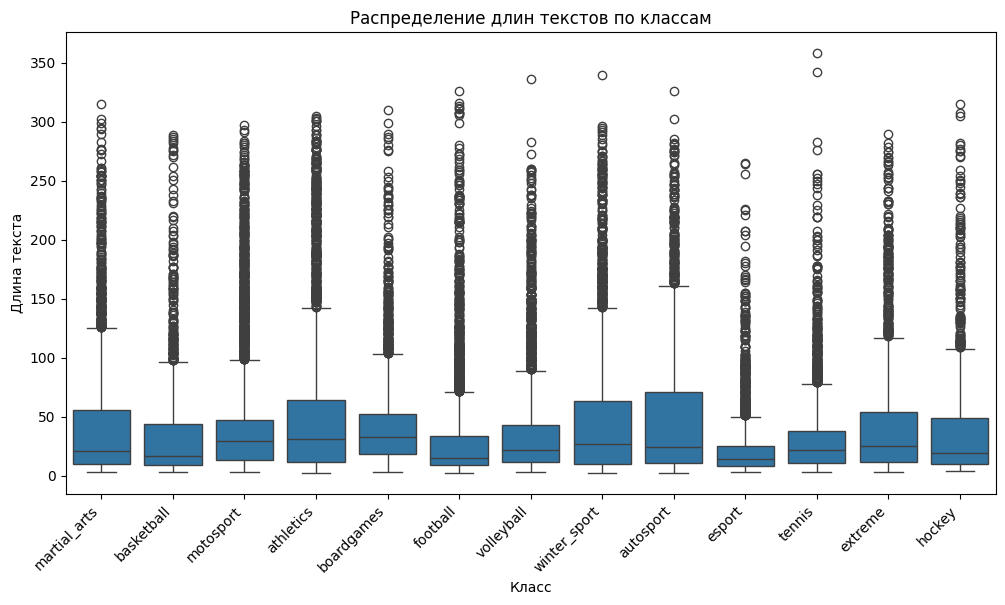

In [ ]:
# Создание ящиковой диаграммы
plt.figure(figsize=(12, 6))
barplot = sns.boxplot(x='class_name', y='length', data=df_)
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, ha='right')

# Настройка заголовка и меток осей
plt.title('Распределение длин текстов по классам')
plt.xlabel('Класс')
plt.ylabel('Длина текста')

# Показать график
plt.show()

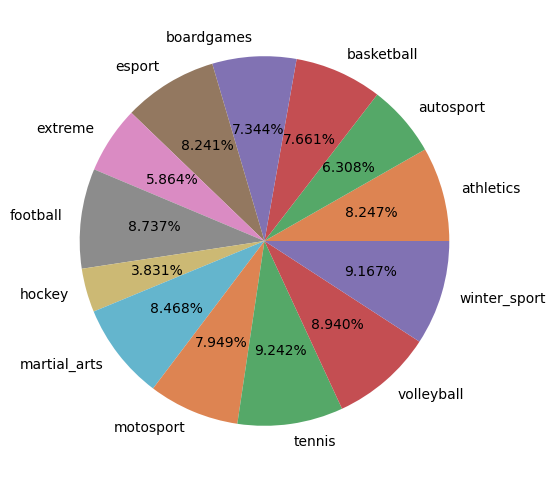

In [ ]:
proportions = df['class_name'].value_counts().sort_index().mul(100) / df.shape[0]
plt.figure(figsize=(12, 6))
colors = sns.color_palette('deep')[1:12]
plt.pie(proportions, labels = proportions.index, colors = colors, autopct='%.3f%%')
plt.show()
plt.show()

## Log Reg

In [ ]:
X = df.drop(columns=['class_name', 'class'], axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RAND)

In [ ]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train['text'])
X_test_tfidf = vectorizer.transform(X_test['text'])

In [ ]:
LogReg = LogisticRegression(multi_class='multinomial', class_weight='balanced', random_state=RAND, solver='saga')
LogReg.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   random_state=10, solver='saga')

In [ ]:
def get_metrics_multiclass(y_test, y_pred, y_prob, name):
    """
    y_test - метки класса без бинаризации
    y_prob - предсказанные вероятности классов
    name - название модели/подхода
    """
    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]

    df_metrics['Precision_micro'] = precision_score(y_test,
                                                    y_pred,
                                                    average='micro')
    df_metrics['Precision_macro'] = precision_score(y_test,
                                                    y_pred,
                                                    average='macro')
    df_metrics['Recall_micro'] = recall_score(y_test, y_pred, average='micro')
    df_metrics['Recall_macro'] = recall_score(y_test, y_pred, average='macro')
    df_metrics['F1_micro'] = f1_score(y_test, y_pred, average='micro')
    df_metrics['F1_macro'] = f1_score(y_test, y_pred, average='macro')
    df_metrics['Logloss'] = log_loss(y_test, y_prob)

    return df_metrics

In [ ]:
model = get_metrics_multiclass(y_test, LogReg.predict(X_test_tfidf), LogReg.predict_proba(X_test_tfidf), 'LR_Base')
model

,model,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,LR_Base,0.826713,0.828805,0.826713,0.822981,0.826713,0.823412,0.753425


## LSTM

In [ ]:
data_train, data_test = train_test_split(df, test_size=0.2, random_state=RAND, stratify=df['class'])
data_train.index = range(len(data_train))
data_test.index = range(len(data_test))

print("Train size = ", len(data_train))
print("Test size = ", len(data_test))

Train size =  38364
Test size =  9591


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
def to_tensors(batch, device):
    batch_tensors = dict()
    batch_tensors['text'] = torch.tensor(batch['text'], device=device, dtype=torch.int64)
    batch_tensors['class'] = torch.tensor(batch['class'], device=device, dtype=torch.int64)
    return batch_tensors

def make_batch(data, max_len=50, device=device):
    batch = {}
    batch["text"] = as_matrix(data["text"].values, max_len)
    batch['class'] = data['class'].values
    return to_tensors(batch, device)

In [ ]:
def iterate_minibatches(data, batch_size=32, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, max_len=50, **kwargs)
            yield batch

        if not cycle: break

In [ ]:
BATCH_SIZE = 32
num_epochs = 13
embed_size = 64
hidden_size = 64
output_size = len(set(df['class'].tolist()))

In [ ]:
class LSTM_Classifier(nn.Module):
    def __init__(self, embed_size, hid_size, out_size, device1, dropout=0.3):
        super(LSTM_Classifier, self).__init__()
        self.hs = hid_size
        self.embs = nn.Embedding(len(token_world), embed_size, device=device1)
        self.lstm = nn.LSTM(embed_size, hid_size, batch_first=True, device=device1)
        self.fc = nn.Linear(hid_size, out_size, device=device1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, idx):
        x = self.embs(idx)
        h0 = torch.zeros(1, x.size(0), self.hs, device=idx.device)
        c0 = torch.zeros(1, x.size(0), self.hs, device=idx.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])  # Apply dropout before the final layer
        out = self.fc(out)
        return out

In [ ]:
model = LSTM_Classifier(embed_size, hidden_size, output_size, device, dropout=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=7e-4) ########

In [ ]:
for epoch in range(num_epochs):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)), total=len(data_train) // BATCH_SIZE):
        pred = model(batch['text'].to(device))
        loss = criterion(pred, batch['class'].to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
lstm_res = get_metrics(model, data_train, BATCH_SIZE, name='lstm_train', device=device)
lstm_res = pd.concat([lstm_res, get_metrics(model, data_test, BATCH_SIZE, name='lstm_test', device=device)])
lstm_res

,model,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro
0,lstm_train,0.900480,0.906006,0.900480,0.892089,0.900480,0.894889
0,lstm_test,0.772495,0.783641,0.772495,0.760754,0.772495,0.765984


# CNN

In [ ]:
BATCH_SIZE = 32
num_epochs = 14
embed_size = 32
num_filters = 64
output_size = len(set(df['class'].tolist()))

In [ ]:
class CNN_Classifier(nn.Module):
    def __init__(self, device1, embed_size=32, num_filters=64, output_size=10, dropout=0.3):
        super(CNN_Classifier, self).__init__()
        self.embs = nn.Embedding(len(token_world), embed_size, device=device1)
        self.conv = nn.Conv1d(embed_size, num_filters, kernel_size=3)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters, output_size)

    def forward(self, idx):
        x = self.embs(idx)
        x = x.transpose(2, 1)
        outs = self.conv(x)
        max_pool = torch.max(outs, dim=-1).values
        max_pool = self.dropout(max_pool)
        output = self.fc(max_pool)
        return output

In [ ]:
model = CNN_Classifier(device, embed_size, num_filters, output_size, dropout=0.35).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=2e-3)

In [ ]:
for epoch in range(num_epochs):
    print(f"epoch: {epoch}")

    model.train()
    for i, batch in tqdm(enumerate(iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)), total=len(data_train) // BATCH_SIZE):
        pred = model(batch['text'].to(device))
        loss = criterion(pred, batch['class'].to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
cnn_res = get_metrics(model, data_train, BATCH_SIZE, name='CNN_train', device=device)
cnn_res = pd.concat([cnn_res, get_metrics(model, data_test, BATCH_SIZE, name='CNN_test', device=device)])
cnn_res

,model,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro
0,CNN_train,0.856506,0.863521,0.856506,0.846115,0.856506,0.851587
0,CNN_test,0.797623,0.813782,0.797623,0.786064,0.797623,0.794664
